# Demo for Effective Dimension Class

In [1]:
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit.utils import QuantumInstance
from qiskit import Aer, QuantumCircuit

In [3]:
from qiskit_machine_learning.algorithms.effective_dimension import EffectiveDimension, LocalEffectiveDimension

In [4]:
# declare quantum instance
qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

## A. Use with Circuit QNN

### 1. Create QNN

In [5]:
# number of times to repeat the variational circuit
blocks = 1

# number of qubits, data samples and parameter sets to estimate the effective dimension
num_qubits = 3
num_inputs = 10
num_thetas = 10

# create ranges for the number of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

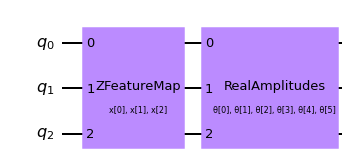

In [6]:
# create a feature map
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

# create a variational circuit
ansatz = RealAmplitudes(num_qubits, reps=blocks)

# create quantum circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))
qc.decompose().draw( 'mpl')

In [7]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [8]:
# construct QNN
qnn = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
    quantum_instance=qi_sv
)

## 2. Create Global Effective Dimension Object

In [9]:
global_ed = EffectiveDimension(qnn=qnn,
                               num_thetas=num_thetas,
                               num_inputs=num_inputs)

## 3. Compute Effective Dimension

In [10]:
# create ranges for the number of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

In [11]:
global_eff_dim, time = global_ed.eff_dim(n = n)
d = global_ed.d

ValueError: cannot reshape array of size 24 into shape (2,6)

In [ ]:
print(time)

In [ ]:
print("effdim: ", global_eff_dim)
# plot the normalised effective dimension for the model
plt.plot(n, np.array(global_eff_dim)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

## 4. Circuit QNN + User-Defined Inputs and Params

In [ ]:
params = np.random.uniform(2, 2.5, size=(num_thetas, qnn.num_weights))
x = np.random.normal(0, 3, size=(num_inputs, qnn.num_inputs))

global_ed = EffectiveDimension(qnn=qnn,
                               thetas=params,
                               inputs=x)

In [ ]:
global_eff_dim, time = global_ed.eff_dim(n = n)
d = global_ed.d
print("effdim: ", global_eff_dim)
# plot the normalised effective dimension for the model
plt.plot(n, np.array(global_eff_dim)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

In [ ]:
# construct QNN
qnn3 = CircuitQNN(
    qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    # interpret=parity,
    # output_shape=output_shape,
    sparse=False,
    quantum_instance=qi_sv
)

In [ ]:
global_ed_3 = EffectiveDimension(qnn=qnn3,
                               thetas=params,
                               inputs=x)

global_eff_dim_3, time = global_ed_3.eff_dim(n = n)
d = global_ed.d
print("effdim: ", global_eff_dim_3)
# plot the normalised effective dimension for the model
plt.plot(n, np.array(global_eff_dim_3)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

## B. Use with Opflow QNN

In [ ]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient

In [ ]:
# specify the observable
observable = PauliSumOp.from_list([("Z" * num_qubits, 1)])
print(observable)
# define two layer QNN
qnn2 = TwoLayerQNN(
    num_qubits, feature_map=feature_map, ansatz=ansatz, observable=observable, quantum_instance=qi_sv
)

In [ ]:
global_ed2 = EffectiveDimension(qnn=qnn2,
                               thetas=params,
                               inputs=x)

In [ ]:
global_eff_dim2, time = global_ed2.eff_dim(n = n)
d = global_ed2.d
print("effdim: ", global_eff_dim2)
# plot the normalised effective dimension for the model
plt.plot(n, np.array(global_eff_dim2)/d)
plt.xlabel('number of data')
plt.ylabel('normalised effective dimension')
plt.show()

## Local Effective Dimension

In [ ]:
local_ed = LocalEffectiveDimension(qnn=qnn2,
                               thetas=params,
                               inputs=x)

In [ ]:
local_ed = LocalEffectiveDimension(qnn=qnn2,
                               thetas=params[0],
                               inputs=x)

In [ ]:
local_ed = LocalEffectiveDimension(qnn=qnn2,
                               thetas=[params[0]],
                               inputs=x)

In [ ]:
local_eff_dim, time = local_ed.eff_dim(n = n)
d = local_ed.d

In [ ]:
print(local_eff_dim)